In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold, cross_val_predict, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer, MinMaxScaler
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, roc_curve, classification_report, precision_recall_curve, auc, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier, plot_importance
from scipy.stats import zscore, uniform, randint
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [12]:
# Read from csv
df = pd.read_csv('02 Stroke Prediction.csv', header= 0).iloc[: , 1:]

# Remove anomalous row for gender
df = df.drop([3116])

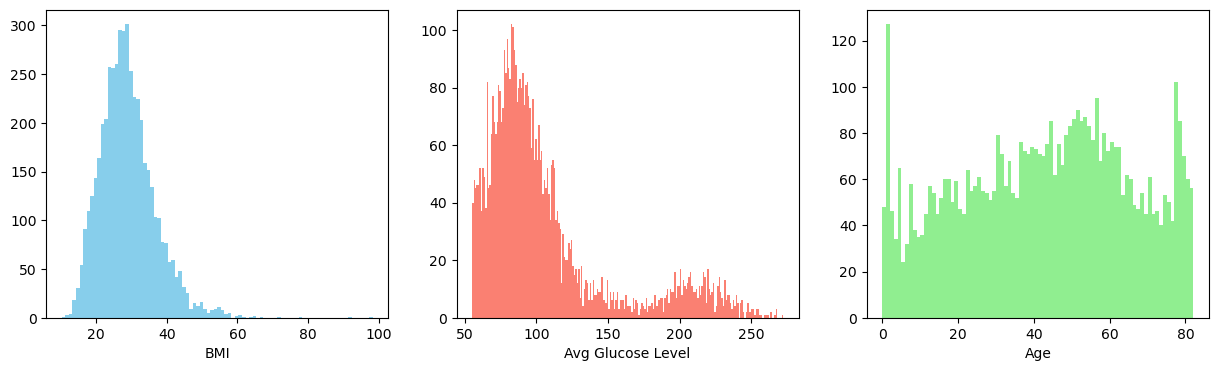

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.hist(df['bmi'], bins=np.arange(df['bmi'].min(), df['bmi'].max() + 1), color='skyblue')
ax1.set(xlabel='BMI')

ax2.hist(df['avg_glucose_level'], bins=np.arange(df['avg_glucose_level'].min(), df['avg_glucose_level'].max() + 1), color='salmon')
ax2.set(xlabel='Avg Glucose Level')

ax3.hist(df['age'], bins=np.arange(df['age'].min(), df['age'].max() + 1), color='lightgreen')
ax3.set(xlabel='Age')

plt.show()

In [14]:
def remove_outliers_normal(data, category, threshold=2):
    z_scores = np.abs((data[category] - np.mean(data[category])) / np.std(data[category]))
    outliers = z_scores > threshold
    return data[~outliers]

# Remove outliers
print(df.shape)
df = remove_outliers_normal(df, 'bmi')
print(df.shape)
df = remove_outliers_normal(df, 'avg_glucose_level')
print(df.shape)

(5109, 11)
(4930, 11)
(4476, 11)


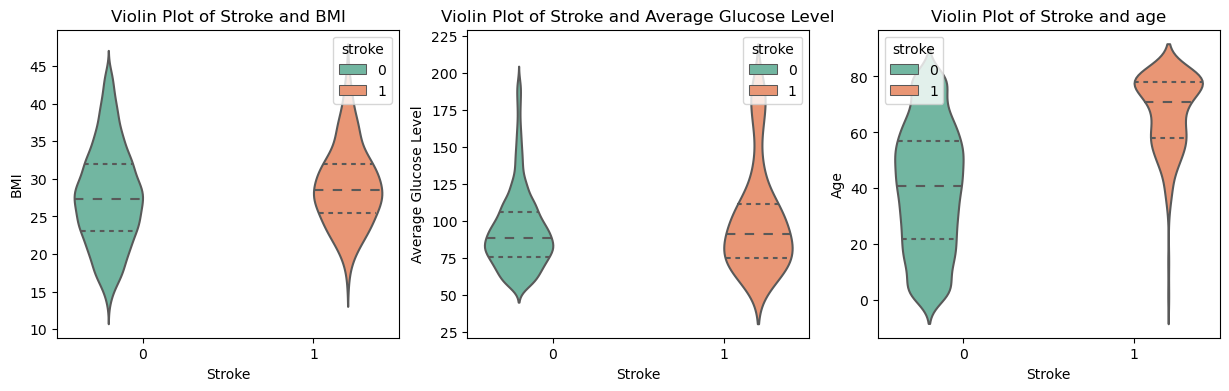

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Create violin plots for each variable
sns.violinplot(x='stroke', y='bmi', data=df, hue='stroke', palette='Set2', inner='quart', ax=ax1)
ax1.set_title('Violin Plot of Stroke and BMI')
ax1.set_xlabel('Stroke')
ax1.set_ylabel('BMI')

sns.violinplot(x='stroke', y='avg_glucose_level', data=df, hue='stroke', palette='Set2', inner='quart', ax=ax2)
ax2.set_title('Violin Plot of Stroke and Average Glucose Level')
ax2.set_xlabel('Stroke')
ax2.set_ylabel('Average Glucose Level')

sns.violinplot(x='stroke', y='age', data=df, hue='stroke', palette='Set2', inner='quart', ax=ax3)
ax3.set_title('Violin Plot of Stroke and age')
ax3.set_xlabel('Stroke')
ax3.set_ylabel('Age')

plt.show()

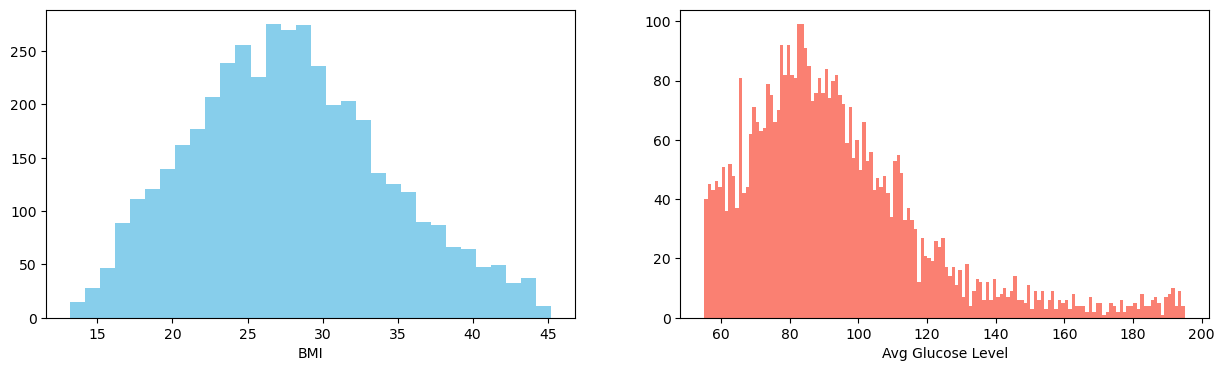

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.hist(df['bmi'], bins=np.arange(df['bmi'].min(), df['bmi'].max() + 1), color='skyblue')
ax1.set(xlabel='BMI')

ax2.hist(df['avg_glucose_level'], bins=np.arange(df['avg_glucose_level'].min(), df['avg_glucose_level'].max() + 1), color='salmon')
ax2.set(xlabel='Avg Glucose Level')

plt.show()

In [17]:
# Change binary classification feature to 0 and 1
for column in ['gender', 'ever_married', 'Residence_type']:
    lbe = LabelEncoder()
    df[column] = lbe.fit_transform(df[column])

# Cardinal ordered encoding for multi-class smoking_status feature
cat_map = {'never smoked': 0, 'formerly smoked': 2, 'smokes': 3, 'Unknown': 1}
df['smoking_status'] = df['smoking_status'].replace(cat_map)

# One Hot Encoding for multi-class work_type feature
one_hot_encoded = pd.get_dummies(df['work_type'], prefix='work_type', dtype=int)
df = df.drop(columns='work_type')
df = pd.concat([df, one_hot_encoded], axis=1)

# Move stroke output to end of dataframe
df['stroke'] = df.pop('stroke')

###

# Separate columns with missing values from the rest of the data
columns_with_missing = df.columns[df.isnull().any()]
columns_without_missing = df.columns.difference(columns_with_missing)

# Create a new DataFrame without missing values for training the model
training_data = df.dropna(subset=columns_with_missing)

# Exclude the target variable from the features
target_variable = 'stroke'
columns_without_missing = columns_without_missing.difference([target_variable])

# Split the data into features (X) and target variable (y)
X_train = training_data[columns_without_missing]
y_train = training_data[columns_with_missing].values.ravel()

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train a machine learning model to predict missing values
model = RandomForestRegressor()  # You can use other models depending on your data
model.fit(X_train, y_train)

# Use the trained model to predict missing values in the original dataset
missing_values_to_predict = df.loc[df[columns_with_missing].isnull().any(axis=1), columns_without_missing]
predicted_missing_values = model.predict(missing_values_to_predict)

# Fill in the missing values in the original dataset
df.loc[df[columns_with_missing].isnull().any(axis=1), columns_with_missing] = predicted_missing_values

# Concatenate the target variable back to the DataFrame
df = pd.concat([df[columns_without_missing], df[columns_with_missing], df[target_variable]], axis=1)

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

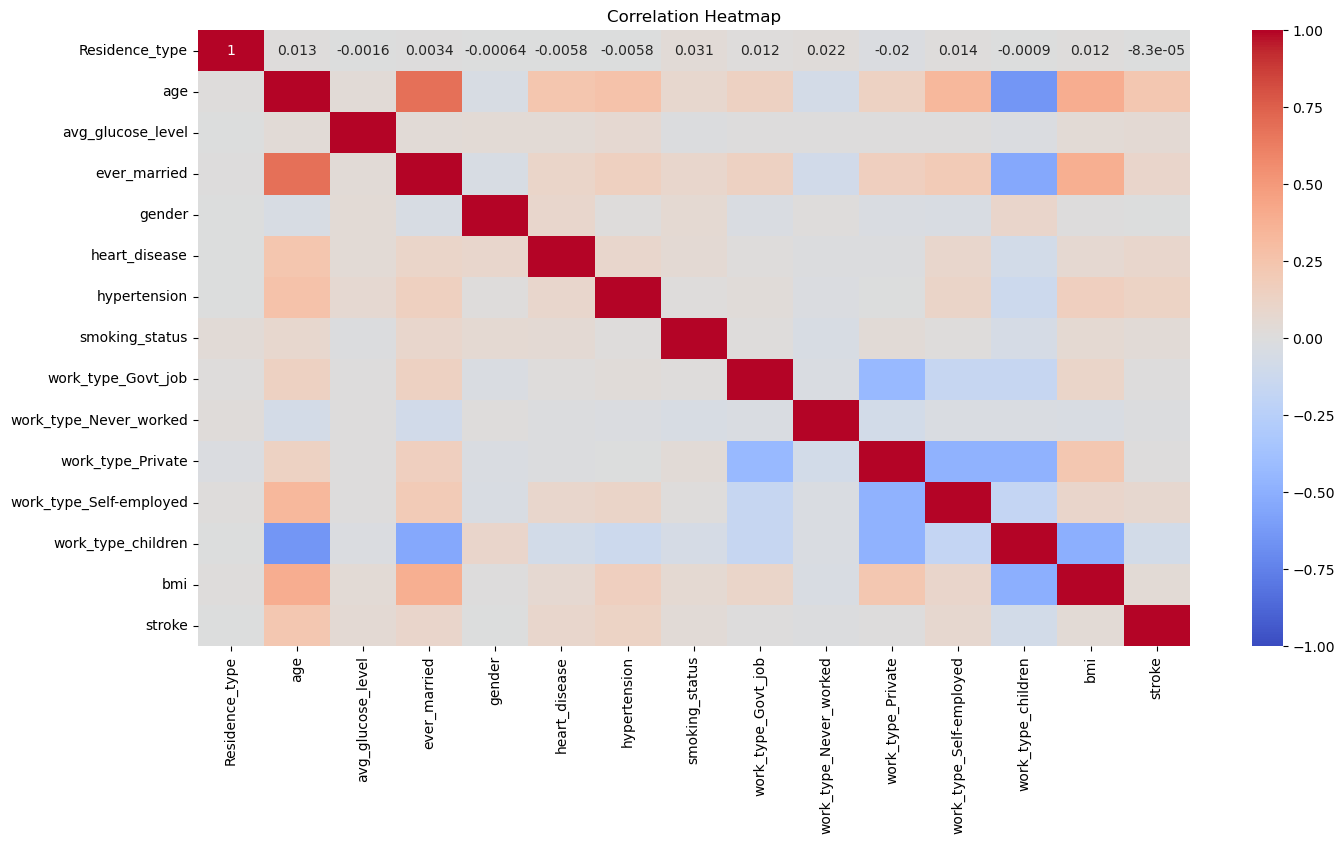

In [18]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

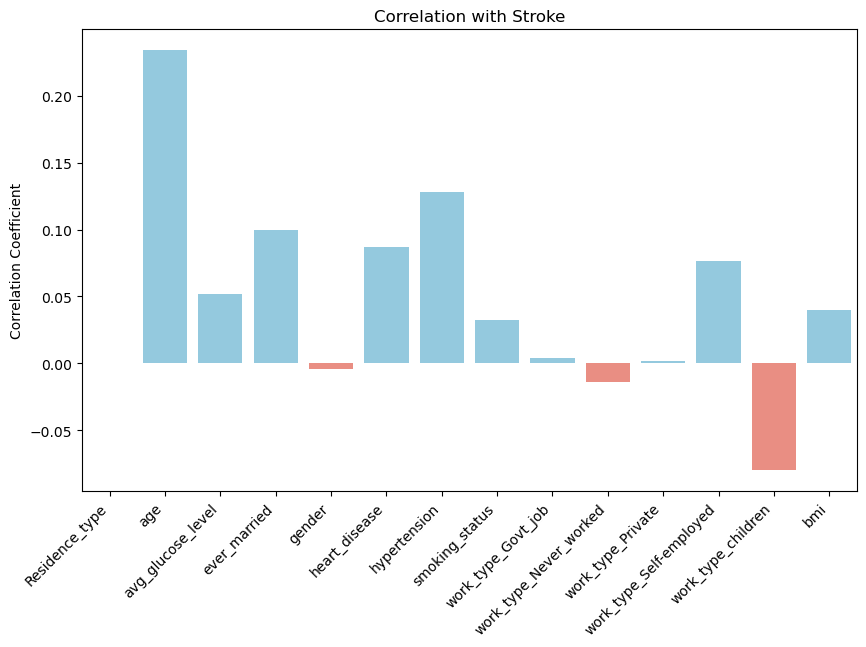

In [19]:
# Calculate the correlation matrix with 'stroke'
correlation_matrix = df.corrwith(df['stroke'])

# Exclude 'stroke' from the x-axis labels
correlation_matrix = correlation_matrix.drop('stroke')

# Define a color map
colors = np.where(correlation_matrix >= 0, 'skyblue', 'salmon')

# Plot the correlation matrix as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_matrix.index, y=correlation_matrix.values, palette=colors)
plt.title('Correlation with Stroke')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45, ha='right')
plt.show()

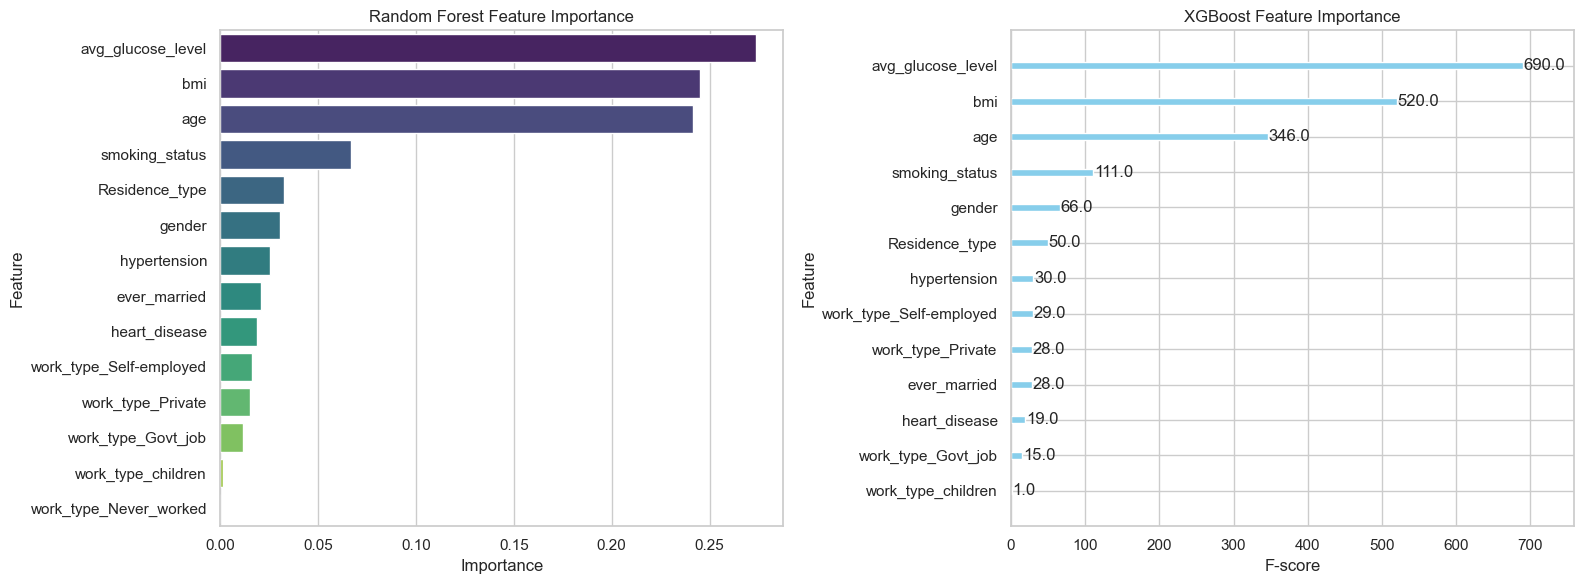

In [20]:
X = df.drop('stroke', axis=1)
y = df['stroke']

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X, y)

# Get feature importances
rf_feature_importances = rf_classifier.feature_importances_

# Create a DataFrame for Random Forest feature importances
rf_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})
rf_importances_df = rf_importances_df.sort_values(by='Importance', ascending=False)

# Create an XGBoost classifier
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X, y)

# Get feature importances for XGBoost
xgb_feature_importances = xgb_classifier.feature_importances_

# Create a DataFrame for XGBoost feature importances
xgb_importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_feature_importances})
xgb_importances_df = xgb_importances_df.sort_values(by='Importance', ascending=False)

# Set seaborn style to 'whitegrid'
sns.set(style="whitegrid")

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plot Random Forest feature importances
sns.barplot(x='Importance', y='Feature', data=rf_importances_df, ax=axes[0], palette='viridis')
axes[0].set_title('Random Forest Feature Importance')
axes[0].set_xlabel('Importance')
axes[0].set_ylabel('Feature')

# Plot XGBoost feature importances
plot_importance(xgb_classifier, importance_type='weight', color='skyblue', ax=axes[1])
axes[1].set_title('XGBoost Feature Importance')
axes[1].set_xlabel('F-score')
axes[1].set_ylabel('Feature')

plt.tight_layout()
plt.show()

In [21]:
# Specify the number of top features to keep
N = 4  # Adjust N as needed

# Get the top N features based on importance
top_N_features = rf_importances_df['Feature'].head(N).tolist()

# Keep only the top N features in the original DataFrame
df_top_N_features = df[top_N_features + ['stroke']]  # Include the target variable if needed

# Display the resulting DataFrame
df = df_top_N_features

# -----------------------------------------------------------------------------------------

In [22]:
# Split into X and y data sets
print(df.shape)
X = df.drop('stroke', axis=1)
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(y_train.shape)

(4476, 5)
(3580,)


In [23]:
# Preprocessing pipeline for logistic regressi
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(class_weight='balanced'))
])

# Preprocessing pipeline for decision tree
tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('tree', DecisionTreeClassifier(class_weight='balanced'))
])

# Preprocessing pipeline for random forest
forest_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('forest', RandomForestClassifier(class_weight='balanced'))
])

# Preprocessing pipeline for XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(random_state=42))
])

# Preprocessing pipeline for SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42))
])

chosen_metric = recall_score

In [24]:
# Define the scoring metric (use f1_score as an example, replace it with your desired metric)
scorer = make_scorer(chosen_metric)

# Randomized search for Logistic Regression
logreg_param_dist = {
    'logreg__C': uniform(0.0001, 1000),  # Expanded range for C
    'logreg__penalty': ['l2']
}

logreg_random = RandomizedSearchCV(logreg_pipeline, logreg_param_dist, n_iter=10, cv=5, scoring=scorer, random_state=42)
logreg_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for Logistic Regression: ", logreg_random.best_params_)
print("Best F1 Score for Logistic Regression: ", logreg_random.best_score_)

Best Parameters for Logistic Regression:  {'logreg__C': 374.54021884736244, 'logreg__penalty': 'l2'}
Best F1 Score for Logistic Regression:  0.8206896551724137


In [25]:
# Define the scoring metric (use f1_score as an example, replace it with your desired metric)
scorer = make_scorer(chosen_metric)

# Randomized search for Decision Tree
tree_param_dist = {
    'tree__max_depth': [None, 10, 20, 30, 50],  # Expanded range for max_depth
    'tree__min_samples_split': randint(2, 20),  # Expanded range for min_samples_split
    'tree__min_samples_leaf': randint(1, 10)  # Expanded range for min_samples_leaf
}

tree_random = RandomizedSearchCV(tree_pipeline, tree_param_dist, n_iter=10, cv=5, scoring=scorer, random_state=42)
tree_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for Decision Tree: ", tree_random.best_params_)
print("Best F1 Score for Decision Tree: ", tree_random.best_score_)

Best Parameters for Decision Tree:  {'tree__max_depth': 10, 'tree__min_samples_leaf': 3, 'tree__min_samples_split': 12}
Best F1 Score for Decision Tree:  0.5034482758620691


In [26]:
# Define the scoring metric (use f1_score as an example, replace it with your desired metric)
scorer = make_scorer(chosen_metric)

# Randomized search for Random Forest
forest_param_dist = {
    'forest__n_estimators': [10, 25, 35, 50, 55, 60, 65, 70, 75, 100],  # Expanded range for n_estimators
    'forest__max_depth': [None, 10, 20, 25, 30, 35, 40, 50],  # Expanded range for max_depth
    'forest__min_samples_split': randint(2, 20),  # Expanded range for min_samples_split
    'forest__min_samples_leaf': randint(1, 10)  # Expanded range for min_samples_leaf
}

forest_random = RandomizedSearchCV(forest_pipeline, forest_param_dist, n_iter=10, cv=5, scoring=scorer, random_state=42)
forest_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for Random Forest: ", forest_random.best_params_)
print("Best F1 Score for Random Forest: ", forest_random.best_score_)

Best Parameters for Random Forest:  {'forest__max_depth': 25, 'forest__min_samples_leaf': 9, 'forest__min_samples_split': 4, 'forest__n_estimators': 55}
Best F1 Score for Random Forest:  0.33103448275862074


In [27]:
# Define the scoring metric (use f1_score as an example, replace it with your desired metric)
scorer = make_scorer(chosen_metric)

# Randomized search for XGBoost
xgb_param_dist = {
    'xgb__learning_rate': uniform(0.001, 0.5),  # Expanded range for learning_rate
    'xgb__max_depth': randint(3, 15),  # Expanded range for max_depth
    'xgb__min_child_weight': randint(1, 10),  # Expanded range for min_child_weight
    'xgb__subsample': uniform(0.6, 0.4)  # Expanded range for subsample
}

xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param_dist, n_iter=10, cv=5, scoring=scorer, random_state=42)
xgb_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for XGBoost: ", xgb_random.best_params_)
print("Best F1 Score for XGBoost: ", xgb_random.best_score_)

Best Parameters for XGBoost:  {'xgb__learning_rate': 0.4926154429033941, 'xgb__max_depth': 11, 'xgb__min_child_weight': 3, 'xgb__subsample': 0.9439761626945282}
Best F1 Score for XGBoost:  0.04827586206896552


In [28]:
# Define the scoring metric (use f1_score as an example, replace it with your desired metric)
scorer = make_scorer(chosen_metric)

# Randomized search for SVM
svm_param_dist = {
    'svm__C': uniform(0.1, 100),  # Expanded range for C
    'svm__gamma': uniform(0.001, 1)  # Expanded range for gamma
}

svm_random = RandomizedSearchCV(svm_pipeline, svm_param_dist, n_iter=10, cv=5, scoring=scorer, random_state=42)
svm_random.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters for SVM: ", svm_random.best_params_)
print("Best F1 Score for SVM: ", svm_random.best_score_)

Best Parameters for SVM:  {'svm__C': 15.701864044243651, 'svm__gamma': 0.15699452033620265}
Best F1 Score for SVM:  0.7448275862068966


In [29]:
# Initialize RandomUnderSampler for majority class and SMOTE for minority class
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=42)
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply undersampling and oversampling to the training set

X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
print(len(y_train_resampled), y_train_resampled.sum())
X_train, y_train = smote.fit_resample(X_train_resampled, y_train_resampled)
print(len(y_train), y_train.sum())

1595 145.0
2900 1450.0


In [30]:
# Train Logistic Regression with the best hyperparameters
logreg_pipeline = logreg_random.best_estimator_
logreg_pipeline.fit(X_train, y_train)

# Train Decision Tree with the best hyperparameters
tree_pipeline = tree_random.best_estimator_
tree_pipeline.fit(X_train, y_train)

# Train Random Forest with the best hyperparameters
forest_pipeline = forest_random.best_estimator_
forest_pipeline.fit(X_train, y_train)

# Train XGBoost with the best hyperparameters
xgb_pipeline = xgb_random.best_estimator_
xgb_pipeline.fit(X_train, y_train)

# Train SVM with the best hyperparameters
svm_pipeline = svm_random.best_estimator_
svm_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm',
                 SVC(C=15.701864044243651, class_weight='balanced',
                     gamma=0.15699452033620265, probability=True,
                     random_state=42))])

In [31]:
# Make predictions

Threshold = 0.5

logreg_probs = logreg_pipeline.predict_proba(X_test)[:, 1]
tree_probs = tree_pipeline.predict_proba(X_test)[:, 1]
forest_probs = forest_pipeline.predict_proba(X_test)[:, 1]
xgb_probs = xgb_pipeline.predict_proba(X_test)[:, 1]
svm_probs = svm_pipeline.predict_proba(X_test)[:, 1]

logreg_preds = (logreg_probs > Threshold).astype(int)
tree_preds = (tree_probs > Threshold).astype(int)
forest_preds = (forest_probs > Threshold).astype(int)
xgb_preds = (xgb_probs > Threshold).astype(int)
svm_preds = (svm_probs > Threshold).astype(int)

In [32]:
# Evaluate the models
def evaluate_model(y_true, y_pred, model_name=''):
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    print(f"Metrics for {model_name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("-" * 50)

In [33]:
# Evaluate each model
evaluate_model(y_test, logreg_preds, model_name='Logistic Regression')
evaluate_model(y_test, tree_preds, model_name='Decision Tree')
evaluate_model(y_test, forest_preds, model_name='Random Forest')
evaluate_model(y_test, xgb_preds, model_name='XGBoost')
evaluate_model(y_test, svm_preds, model_name='SVM')

Metrics for Logistic Regression:
Accuracy: 0.7310
Precision: 0.1132
Recall: 0.8333
F1 Score: 0.1993
ROC AUC: 0.7800

Confusion Matrix:
[[625 235]
 [  6  30]]
--------------------------------------------------
Metrics for Decision Tree:
Accuracy: 0.7734
Precision: 0.1222
Recall: 0.7500
F1 Score: 0.2101
ROC AUC: 0.7622

Confusion Matrix:
[[666 194]
 [  9  27]]
--------------------------------------------------
Metrics for Random Forest:
Accuracy: 0.8192
Precision: 0.1649
Recall: 0.8611
F1 Score: 0.2768
ROC AUC: 0.8393

Confusion Matrix:
[[703 157]
 [  5  31]]
--------------------------------------------------
Metrics for XGBoost:
Accuracy: 0.8605
Precision: 0.1550
Recall: 0.5556
F1 Score: 0.2424
ROC AUC: 0.7144

Confusion Matrix:
[[751 109]
 [ 16  20]]
--------------------------------------------------
Metrics for SVM:
Accuracy: 0.7600
Precision: 0.1286
Recall: 0.8611
F1 Score: 0.2238
ROC AUC: 0.8085

Confusion Matrix:
[[650 210]
 [  5  31]]
----------------------------------------------

In [34]:
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_probs)
fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_probs)
fpr_forest, tpr_forest, _ = roc_curve(y_test, forest_probs)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_probs)
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_probs)

prc_logreg, rcl_logreg, thrsh_logreg = precision_recall_curve(y_test, logreg_probs)
prc_tree, rcl_tree, thrsh_tree = precision_recall_curve(y_test, tree_probs)
prc_forest, rcl_forest, thrsh_forest = precision_recall_curve(y_test, forest_probs)
prc_xgb, rcl_xgb, thrsh_xgb = precision_recall_curve(y_test, xgb_probs)
prc_svm, rcl_svm, thrsh_svm = precision_recall_curve(y_test, svm_probs)

f1_logreg = [f1_score(y_test, logreg_probs >= threshold) for threshold in thrsh_logreg]
f1_tree = [f1_score(y_test, tree_probs >= threshold) for threshold in thrsh_tree]
f1_forest = [f1_score(y_test, forest_probs >= threshold) for threshold in thrsh_forest]
f1_xgb = [f1_score(y_test, xgb_probs >= threshold) for threshold in thrsh_xgb]
f1_svm = [f1_score(y_test, svm_probs >= threshold) for threshold in thrsh_svm]

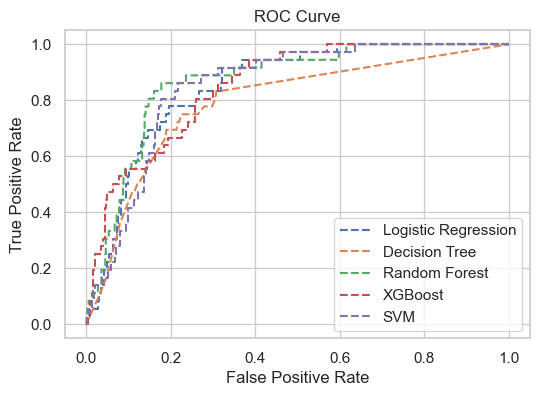

In [35]:
plt.figure(figsize=(6,4))
plt.plot(fpr_logreg, tpr_logreg, linestyle='--', label='Logistic Regression')
plt.plot(fpr_tree, tpr_tree, linestyle='--', label='Decision Tree')
plt.plot(fpr_forest, tpr_forest, linestyle='--', label='Random Forest')
plt.plot(fpr_xgb, tpr_xgb, linestyle='--', label='XGBoost')
plt.plot(fpr_svm, tpr_svm, linestyle='--', label='SVM')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

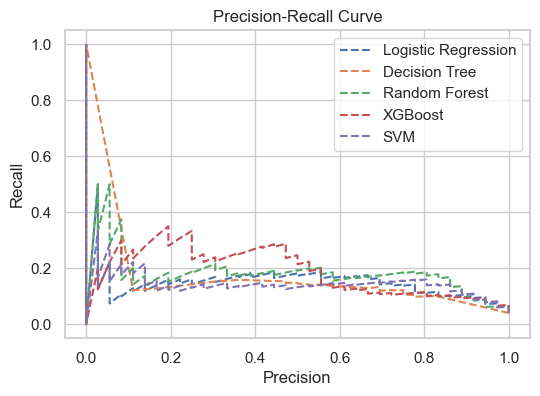

In [36]:
plt.figure(figsize=(6, 4))
plt.plot(rcl_logreg, prc_logreg, linestyle='--', label='Logistic Regression')
plt.plot(rcl_tree, prc_tree, linestyle='--', label='Decision Tree')
plt.plot(rcl_forest, prc_forest, linestyle='--', label='Random Forest')
plt.plot(rcl_xgb, prc_xgb, linestyle='--', label='XGBoost')
plt.plot(rcl_svm, prc_svm, linestyle='--', label='SVM')

plt.title('Precision-Recall Curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.show()

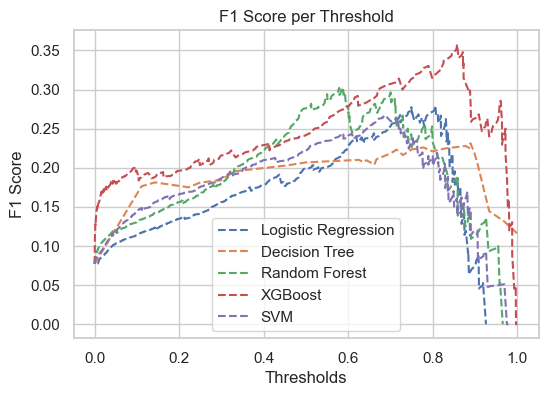

In [37]:
plt.figure(figsize=(6, 4))
plt.plot(thrsh_logreg, f1_logreg, linestyle='--', label='Logistic Regression')
plt.plot(thrsh_tree, f1_tree, linestyle='--', label='Decision Tree')
plt.plot(thrsh_forest, f1_forest, linestyle='--', label='Random Forest')
plt.plot(thrsh_xgb, f1_xgb, linestyle='--', label='XGBoost')
plt.plot(thrsh_svm, f1_svm, linestyle='--', label='SVM')

plt.title('F1 Score per Threshold')
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

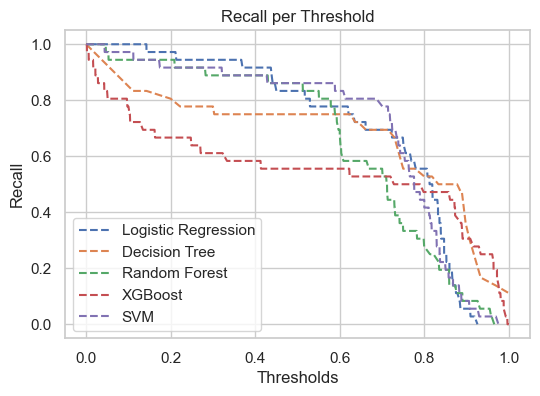

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(thrsh_logreg, rcl_logreg[:-1], linestyle='--', label='Logistic Regression')
plt.plot(thrsh_tree, rcl_tree[:-1], linestyle='--', label='Decision Tree')
plt.plot(thrsh_forest, rcl_forest[:-1], linestyle='--', label='Random Forest')
plt.plot(thrsh_xgb, rcl_xgb[:-1], linestyle='--', label='XGBoost')
plt.plot(thrsh_svm, rcl_svm[:-1], linestyle='--', label='SVM')

plt.title('Recall per Threshold')
plt.xlabel('Thresholds')
plt.ylabel('Recall')
plt.legend(loc='best')
plt.show()

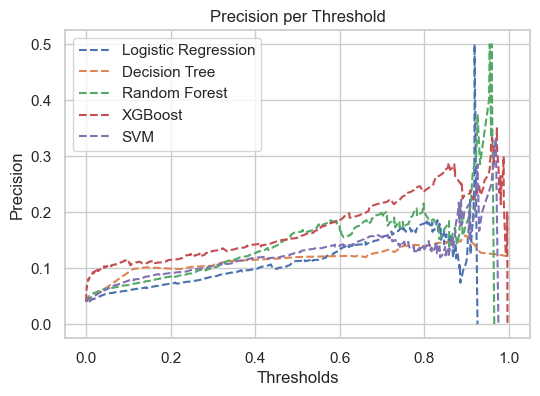

In [39]:
plt.figure(figsize=(6, 4))
plt.plot(thrsh_logreg, prc_logreg[:-1], linestyle='--', label='Logistic Regression')
plt.plot(thrsh_tree, prc_tree[:-1], linestyle='--', label='Decision Tree')
plt.plot(thrsh_forest, prc_forest[:-1], linestyle='--', label='Random Forest')
plt.plot(thrsh_xgb, prc_xgb[:-1], linestyle='--', label='XGBoost')
plt.plot(thrsh_svm, prc_svm[:-1], linestyle='--', label='SVM')

plt.title('Precision per Threshold')
plt.xlabel('Thresholds')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.show()

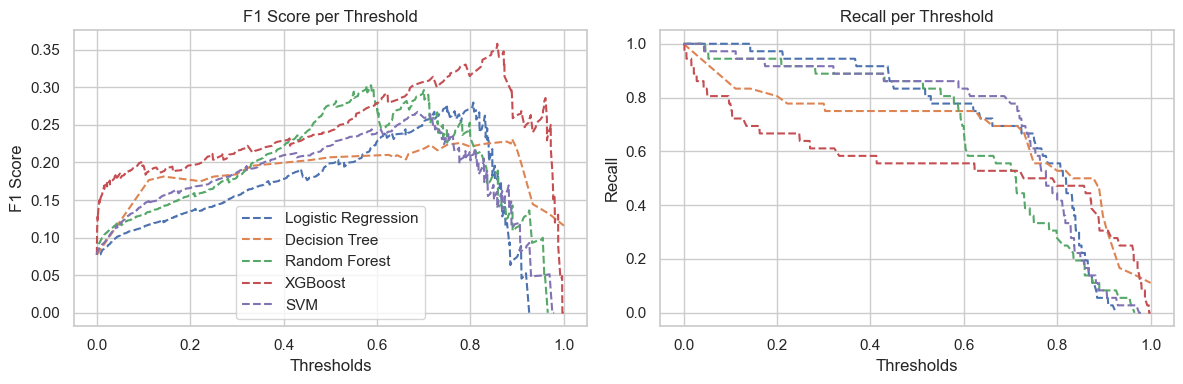

In [40]:
# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot F1 Score per Threshold
axes[0].plot(thrsh_logreg, f1_logreg, linestyle='--', label='Logistic Regression')
axes[0].plot(thrsh_tree, f1_tree, linestyle='--', label='Decision Tree')
axes[0].plot(thrsh_forest, f1_forest, linestyle='--', label='Random Forest')
axes[0].plot(thrsh_xgb, f1_xgb, linestyle='--', label='XGBoost')
axes[0].plot(thrsh_svm, f1_svm, linestyle='--', label='SVM')

axes[0].set_title('F1 Score per Threshold')
axes[0].set_xlabel('Thresholds')
axes[0].set_ylabel('F1 Score')

# Plot Recall per Threshold
axes[1].plot(thrsh_logreg, rcl_logreg[:-1], linestyle='--', label='Logistic Regression')
axes[1].plot(thrsh_tree, rcl_tree[:-1], linestyle='--', label='Decision Tree')
axes[1].plot(thrsh_forest, rcl_forest[:-1], linestyle='--', label='Random Forest')
axes[1].plot(thrsh_xgb, rcl_xgb[:-1], linestyle='--', label='XGBoost')
axes[1].plot(thrsh_svm, rcl_svm[:-1], linestyle='--', label='SVM')

axes[1].set_title('Recall per Threshold')
axes[1].set_xlabel('Thresholds')
axes[1].set_ylabel('Recall')

# Add a single legend for both subplots
axes[0].legend(loc='best')

# Adjust layout for better appearance
plt.tight_layout()
plt.show()